In [9]:
import pandas as pd, matplotlib.pyplot as plt, gzip, json, os

## Images Resolution Analysis

In [10]:
images_data = pd.read_csv('images.csv')

In [11]:
images_data.head()

,image_id,height,width,path
0,010-mllS7JL,106,106,14/14fe8812.jpg
1,01dkn0Gyx0L,122,122,da/daab0cad.jpg
2,01sUPg0387L,111,111,d2/d2daaae9.jpg
3,1168jc-5r1L,186,186,3a/3a4e88e6.jpg
4,11RUV5Fs65L,30,500,d9/d91ab9cf.jpg


In [12]:
images_data.dtypes

image_id    object
height       int64
width        int64
path        object
dtype: object

Let us filter all non-quadratic shaped images out

In [13]:
images_data[
    images_data['height'] == images_data['width']
]['height'].value_counts()

height
2560    45005
1000    24945
2000    16154
1500    13813
1200     7518
        ...  
1157        1
1135        1
1269        1
1717        1
1897        1
Name: count, Length: 1572, dtype: int64

Images of size 2560x2560 are the most common. What about both quadratic and rectangular images?

In [14]:
(images_data['height'].astype(str) + 'x' + images_data['width'].astype(str)).value_counts()

2200x1879    92513
2560x2560    45005
1000x1000    24945
2000x2000    16154
1500x1500    13813
             ...  
2086x1941        1
1137x2529        1
1230x754         1
883x2375         1
2372x2397        1
Name: count, Length: 45719, dtype: int64

There are about 2x more images with the 2200x1879 resolution compared to the 2560x2560. However, how many various values for height and width do we have in general?

<Axes: title={'center': 'Width'}, ylabel='Frequency'>

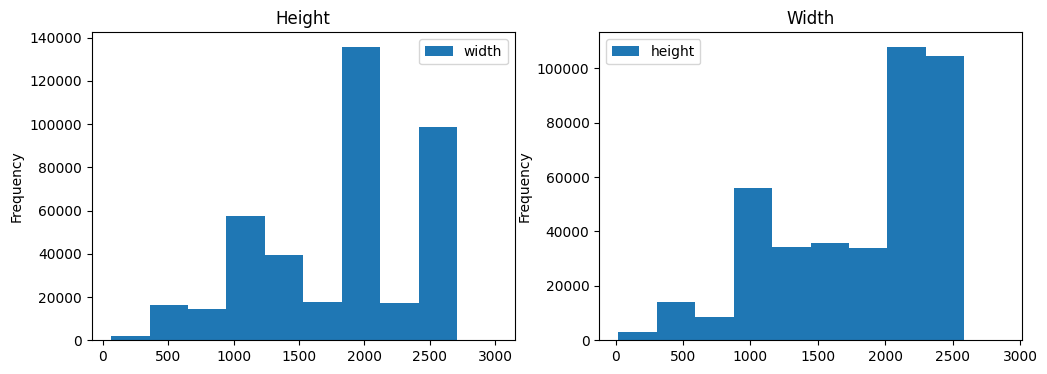

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

images_data.plot(kind='hist', x='height', ax=ax1, title='Height')
images_data.plot(kind='hist', x='width', ax=ax2, title='Width')

Evidently, we have both quite small and large images as well. Since the data is this diverse, we should decide upon a uniform resolution for our images:

1. 2200x1879 (92513 images)
2. 2560x2560 (45005 images)

In [16]:
# 2200x1879
images_2200x1879 = images_data[
    (images_data['height'] == 2200) &
    (images_data['width'] == 1879)
]

## Images Metadata Parsing

First, let us extract the category for (ideally) each image. We will create a list of dictionaries:
```
[
    {"image_id": "category},
    ...
]
```

In [17]:
gz_files = os.listdir('metadata')
gz_files = [i for i in gz_files if i != '.DS_Store']

image_metadata = []

for f in gz_files:
    with gzip.open(f'metadata/{f}', "rt", encoding='utf-8') as gz_file:
        gz_data = gz_file.read()
        gz_data_list = gz_data.split('\n')
        
        # need to parse line by line, otherwise there is an error
        for line in gz_data_list[:-1]:
            data = json.loads(line)
            try:
                image_metadata.append(
                    {
                        data['main_image_id']: [
                            data['product_type'][0]['value'],
                            data['model_name'][0]['value'],
                            data['brand'][0]['value'],
                            data['country'],
                            data['item_name'][0]['value'],
                            data['marketplace'],
                        ]
                    }
                )
                # can get more other info, see README.md for details
            except KeyError:
                pass

In [18]:
image_metadata_df = pd.DataFrame(
    {
        'image_id': [list(i.keys())[0] for i in image_metadata],
        'category': [list(i.values())[0][0] for i in image_metadata],
        'model_name': [list(i.values())[0][1] for i in image_metadata],
        'brand': [list(i.values())[0][2] for i in image_metadata],
        'country': [list(i.values())[0][3] for i in image_metadata],
        'item_name': [list(i.values())[0][4] for i in image_metadata],
        'marketplace': [list(i.values())[0][5] for i in image_metadata],
    }
)

In [19]:
image_metadata_df_2200x1879 = image_metadata_df.merge(images_2200x1879)

Let us see what categories we get for the images of size 2200x1879 px

In [20]:
image_metadata_df_2200x1879['category'].value_counts()

category
CELLULAR_PHONE_CASE    54815
Name: count, dtype: int64

It seems only phone cases are represented by the images of this size. Let us see what categories we have in the full dataset

In [21]:
image_metadata_df['category'].value_counts()

category
CELLULAR_PHONE_CASE         64559
SHOES                        7702
BOOT                         1934
SANDAL                       1784
FINERING                      578
                            ...  
BODY_POSITIONER                 1
ABIS_ELECTRONICS                1
CAMERA_OTHER_ACCESSORIES        1
CHARGING_ADAPTER                1
DISHWARE_BOWL                   1
Name: count, Length: 235, dtype: int64

All in all, phone cases is the most popular category of all the listings. I think we can reduce the problem to extracting top N similar phone cases base on the user input. Consider the following scenario:

1. A user finds a nice case on Pinterest, from a friend, etc.
2. They are obviously not sure which words to use to describe it
3. Consequently, it becomes difficult for them to buy such a case
4. As a solution, they can use our service, which will look similar cases up

The problem is quite challenging, since the model has to be able to determine all the subtle features of the case, e.g., Hello Kitty pic, stars, flowers, etc.

Now we shall come up with a target variable for the CNN. Training the model to distinguish phone brands the cases are made for could be reasonable, since at the very least the model should recommend iphone cases when the user uploads an iphone case picture. Assuming the brand name comes first, let us try and extract the phone manufacturers names

In [22]:
image_metadata_df_2200x1879['phone_brand'] = image_metadata_df_2200x1879['model_name'].\
    str.lower().\
    str.replace('\xa0', ' ').\
    apply(lambda x: x[:x.find(' ')])

In [23]:
image_metadata_df_2200x1879['phone_brand'].value_counts()

phone_brand
samsung          10315
vivo              5303
oppo              3450
micromax          2830
lenovo            2805
                 ...  
gz8602-sl4059        1
gz8599-sl4051        1
gz8623-sl4045        1
gz8632-sl4077        1
gz8462-sl4068        1
Name: count, Length: 225, dtype: int64

There is a bunch of "gz" phones, we can combine them into one brand name

In [24]:
image_metadata_df_2200x1879['phone_brand'] = image_metadata_df_2200x1879['phone_brand'].str.replace(r'^gz\d{4}-sl\d{4}', 'gz', regex=True)

In [25]:
image_metadata_df_2200x1879['phone_brand'].value_counts()

phone_brand
samsung           10315
vivo               5303
oppo               3450
micromax           2830
lenovo             2805
apple              2761
motorola           2526
gionee             2488
lg                 2417
huawei             2098
nokia              2048
asus               1844
sony               1671
xiaomi             1444
mi                 1163
oneplus            1068
realme              955
coolpad             794
lyf                 641
lava                625
htc                 580
infocus             520
tecno               456
poco                404
panasonic           395
microsoft           336
itel                288
letv                276
moto                237
comio               213
gz                  191
leeco               184
meizu               180
i                   177
honor               168
10.or               158
karbonn             130
infinix             124
spice                99
ivoomi               90
intex                61
mobi

We have already reduced the number of classes quite significantly. However, there are also 2 categories with only 1 observation. Galaxy clearly refers to Samsung, and by googling "uv10920" we can find out that it is actually a [Redmi](https://www.amazon.in/Amazon-Brand-Designer-Sparkle-Printed/dp/B085S3SBM7) smartphone case

In [26]:
image_metadata_df_2200x1879['phone_brand'] = image_metadata_df_2200x1879['phone_brand'].\
    str.replace('galaxy', 'samsung').\
    str.replace('uv10920-sl4050', 'redmi')

In [27]:
image_metadata_df_2200x1879['phone_brand'].value_counts()

phone_brand
samsung      10316
vivo          5303
oppo          3450
micromax      2830
lenovo        2805
apple         2761
motorola      2526
gionee        2488
lg            2417
huawei        2098
nokia         2048
asus          1844
sony          1671
xiaomi        1444
mi            1163
oneplus       1068
realme         955
coolpad        794
lyf            641
lava           625
htc            580
infocus        520
tecno          456
poco           404
panasonic      395
microsoft      336
itel           288
letv           276
moto           237
comio          213
gz             191
leeco          184
meizu          180
i              177
honor          168
10.or          158
karbonn        130
infinix        124
spice           99
ivoomi          90
intex           61
mobiistar       55
nexus           51
ikall           46
redmi           45
techno          42
lephone         30
acer            17
fluo            15
Name: count, dtype: int64

In [28]:
image_metadata_df_2200x1879['phone_brand'].value_counts().shape

(49,)

All in all, we end up with 49 unique brands in total. We can either set a threshold and combine some underrepresented classes into one category, or proceed with 49 classes

In [29]:
image_metadata_df_2200x1879.to_csv('images_phone_cases.csv', index=False)

In [30]:
image_metadata_df_2200x1879

,image_id,category,model_name,brand,country,item_name,marketplace,height,width,path,phone_brand
0,81+4dBN1jsL,CELLULAR_PHONE_CASE,Mi Redmi Go,Amazon Brand - Solimo,IN,Amazon Brand - Solimo Designer Autumn Girl 3D ...,Amazon,2200,1879,9d/9dfccb37.jpg,mi
1,71tgJqobw6L,CELLULAR_PHONE_CASE,Vivo Y81i,Amazon Brand - Solimo,IN,Amazon Brand - Solimo Designer Butterflies Neo...,Amazon,2200,1879,77/77412532.jpg,vivo
2,71Ajg8gQEoL,CELLULAR_PHONE_CASE,Karbonn Aura Power 4G Plus,Amazon Brand - Solimo,IN,Amazon Brand - Solimo Designer Autumn Girl UV ...,Amazon,2200,1879,5f/5f0c12f2.jpg,karbonn
3,71z2XJ0DW2L,CELLULAR_PHONE_CASE,Samsung Galaxy A70s,Amazon Brand - Solimo,IN,Amazon Brand - Solimo Designer Water Drop On G...,Amazon,2200,1879,8b/8b519b9b.jpg,samsung
4,81RNHjN1X5L,CELLULAR_PHONE_CASE,Motorola Moto G4 Plus,Amazon Brand - Solimo,IN,Amazon Brand - Solimo Designer Cactus 3D Print...,Amazon,2200,1879,a1/a1774265.jpg,motorola
...,...,...,...,...,...,...,...,...,...,...,...
54810,81Bt9CB2CfL,CELLULAR_PHONE_CASE,Panasonic Eluga I3,Amazon Brand - Solimo,IN,Amazon Brand - Solimo Designer Queen On Red Gl...,Amazon,2200,1879,1d/1d9960b0.jpg,panasonic
54811,81HjO6sRWGL,CELLULAR_PHONE_CASE,Sony Xperia L2,Amazon Brand - Solimo,IN,Amazon Brand - Solimo Designer No 3D Printed H...,Amazon,2200,1879,98/98ad24f7.jpg,sony
54812,71XYHEPKdpL,CELLULAR_PHONE_CASE,Huawei Honor 4C,Amazon Brand - Solimo,IN,Amazon Brand - Solimo Designer Apple Texture 3...,Amazon,2200,1879,5c/5c95a488.jpg,huawei
54813,71xgAzHOVeL,CELLULAR_PHONE_CASE,Oppo F15,Amazon Brand - Solimo,IN,Amazon Brand - Solimo Designer Daddy's Girl in...,Amazon,2200,1879,fa/faa42b52.jpg,oppo


lets create a list if all item)names and see most common words

In [60]:
from collections import Counter

word_counts = Counter()
image_metadata_df_2200x1879['item_name'].str.split().apply(word_counts.update)

# Sort by count
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)


In [62]:
for a in sorted_word_counts[:50]:
    print(a)

('for', 54878)
('Amazon', 54815)
('-', 54815)
('Solimo', 54815)
('Brand', 54813)
('Designer', 54810)
('Printed', 54810)
('Back', 54810)
('Case', 54810)
('Mobile', 54810)
('Cover', 54810)
('3D', 39462)
('Hard', 39457)
('UV', 15353)
('Soft', 15353)
('Samsung', 10339)
('Galaxy', 10017)
('Plus', 5496)
('Vivo', 5290)
('Texture', 5188)
('Pro', 4314)
('Pattern', 4141)
('Canvas', 3570)
('Oppo', 3450)
('On', 3260)
('Girl', 3246)
('Color', 3099)
('Multicolor', 3001)
('Max', 2940)
('Apple', 2890)
('Note', 2846)
('Micromax', 2830)
('Lenovo', 2809)
('and', 2756)
('Redmi', 2718)
('iPhone', 2661)
('Moto', 2576)
('Motorola', 2535)
('2', 2497)
('Gionee', 2488)
('LG', 2417)
('Cut)', 2248)
('3', 2160)
('Huawei', 2111)
('Nokia', 2064)
('/', 2023)
('Red', 1949)
('Asus', 1858)
('Pink', 1821)
('Zenfone', 1780)


In [31]:
image_metadata_df_2200x1879.dtypes

image_id       object
category       object
model_name     object
brand          object
country        object
item_name      object
marketplace    object
height          int64
width           int64
path           object
phone_brand    object
dtype: object

Lets write code to access the image file as well as preview it

In [32]:
record = image_metadata_df_2200x1879.iloc[0]
record

image_id                                             81+4dBN1jsL
category                                     CELLULAR_PHONE_CASE
model_name                                           Mi Redmi Go
brand                                      Amazon Brand - Solimo
country                                                       IN
item_name      Amazon Brand - Solimo Designer Autumn Girl 3D ...
marketplace                                               Amazon
height                                                      2200
width                                                       1879
path                                             9d/9dfccb37.jpg
phone_brand                                                   mi
Name: 0, dtype: object

In [33]:
import os
from dotenv import load_dotenv

load_dotenv()

folder_path = os.getenv('INIT_FOLDER_PATH')
folder_path

images_path = os.path.join(folder_path, 'images')
images_path

'D:\\abo\\images'

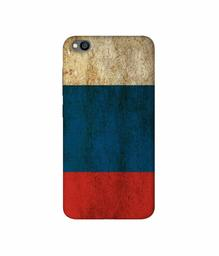

In [34]:
from IPython.display import Image

image_path = os.path.join(images_path,'small',record.path)

Image(image_path)

In [35]:
new_dir_path = os.path.join(images_path, 'phone_cases')

In [36]:
os.makedirs(new_dir_path, exist_ok=True)

In [51]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

# Create the new directory if it doesn't exist
os.makedirs(new_dir_path, exist_ok=True)

# Iterate through each row in the DataFrame with a progress bar
for index, row in tqdm(image_metadata_df_2200x1879.iterrows(), total=len(image_metadata_df_2200x1879), desc='Copying and organizing images'):
    # Get the phone brand and create a subdirectory for it
    phone_brand_dir = os.path.join(new_dir_path, row['phone_brand'])
    os.makedirs(phone_brand_dir, exist_ok=True)
    
    path_splited = row['path'].split('/')
    last_path = path_splited[1]

    # Build the source file path
    src_path = os.path.join(images_path,'small',row['path'])
    
    # Build the destination file path
    dst_path = os.path.join(phone_brand_dir, last_path)
    
    # Check if the file already exists at the destination path
    if not os.path.exists(dst_path):
        # Check if the source file exists
        if os.path.exists(src_path):
            # Copy the file to the subdirectory if the source file exists and the destination file doesn't
            shutil.copy(src_path, dst_path)
    #     else:
    #         print(f'Source file not found: {src_path}')
    # else:
    #     print(f'file already exists')


phone_cases_path = new_dir_path

Copying and organizing images:  69%|██████▉   | 37713/54815 [00:18<00:08, 2003.63it/s]


KeyboardInterrupt: 

In [41]:
import tensorflow as tf

dims = (224, 224)

batch_size = 32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=new_dir_path,
    labels='inferred',
    label_mode='int', 
    image_size= dims,
    batch_size=batch_size
)

dataset

Found 54659 files belonging to 49 classes.


<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [42]:
base_model = tf.keras.applications.MobileNetV2(input_shape=dims + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model


In [54]:
from tensorflow import keras

model = tf.keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(49, activation='softmax')  # Assuming there are 49 classes as per your dataset
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               16056576  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 49)               

In [55]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [56]:
tf.random.set_seed(1)

train_dataset = dataset.take(int(0.8 * len(dataset)))  # 80% for training
val_dataset = dataset.skip(int(0.8 * len(dataset)))  # 20% for validation


In [57]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [63]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=5)


Epoch 1/5
1367/1367 [==============================] - 498s 363ms/step - loss: 3.1105 - accuracy: 0.1889 - val_loss: 3.0853 - val_accuracy: 0.1873
Epoch 2/5
1030/1367 [=====================>........] - ETA: 25s - loss: 3.1054 - accuracy: 0.1874

KeyboardInterrupt: 